In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
import tensorflow as tf

In [2]:
df = pd.read_csv("data.csv")
df = df.rename(columns={"tension_strenght": "tensile_strength"})
df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     object 
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     object 
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tensile_strength    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB


In [4]:
for column in df.columns:
    print(str(column)+": "+str(df[column].unique()))
    print()

layer_height: [0.02 0.06 0.1  0.15 0.2 ]

wall_thickness: [ 8  7  1  4  6 10  5  9  2  3]

infill_density: [90 80 70 40 10 20 50 30 60]

infill_pattern: ['grid' 'honeycomb']

nozzle_temperature: [220 225 230 240 250 200 205 210 215]

bed_temperature: [60 65 70 75 80]

print_speed: [ 40  60 120]

material: ['abs' 'pla']

fan_speed: [  0  25  50  75 100]

roughness: [ 25  32  40  68  92  60  55  21  24  30  75 118 200 220 126 145  88  74
 120 144 265 312 368 180 176 128 138 121 168 154 225 289 326 192 212 172
 163 276 298 360 357 321 278 244]

tensile_strength: [18 16  8 10  5 24 12 14 27 25 37  9 23 26 33 29 19 11 34 13 22  4 35 28
 21 30]

elongation: [1.2 1.4 0.8 0.5 0.7 1.1 1.3 1.5 1.7 2.4 1.  2.2 1.9 1.6 2.1 2.  0.9 0.4
 1.8 2.9 0.6 2.8 2.3 3.3 3.1 2.7 3.2]



In [5]:
#In this data set, ABS and PLA assigned 0 and 1 values for materials (abs = 0, pla = 1)
df.material = [0 if each=='abs' else 1 for each in df.material]

#In this data set, grid and honeycomb assigned 0 and 1 values for infill_pattern (grid = 0, honeycomb = 1)
df.infill_pattern = [0 if each=='grid' else 1 for each in df.infill_pattern]

df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.02,8,90,0,220,60,40,0,0,25,18,1.2
1,0.02,7,90,1,225,65,40,0,25,32,16,1.4
2,0.02,1,80,0,230,70,40,0,50,40,8,0.8
3,0.02,4,70,1,240,75,40,0,75,68,10,0.5
4,0.02,6,90,0,250,80,40,0,100,92,5,0.7


In [6]:
df.layer_height = df.layer_height*100
df.elongation = df.elongation*100

In [7]:
df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,2.0,8,90,0,220,60,40,0,0,25,18,120.0
1,2.0,7,90,1,225,65,40,0,25,32,16,140.0
2,2.0,1,80,0,230,70,40,0,50,40,8,80.0
3,2.0,4,70,1,240,75,40,0,75,68,10,50.0
4,2.0,6,90,0,250,80,40,0,100,92,5,70.0


In [14]:
output_drops = ['roughness', 'elongation']
df = df.drop(output_drops, axis=1)

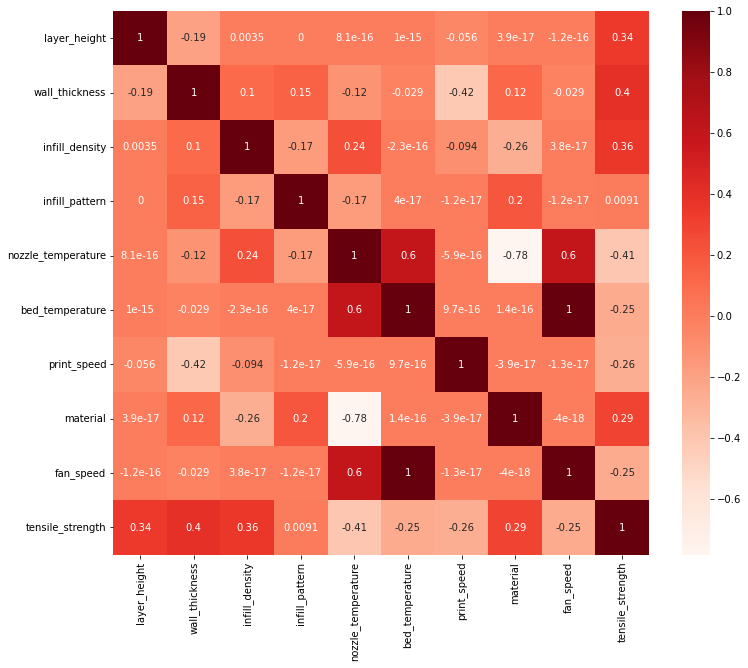

In [15]:
import seaborn as sns
plt.figure(figsize=(12,10))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds) #Using Pearson Correlation
plt.show()

In [47]:
target_cols = ['tensile_strength']
Y = df[target_cols]
X1 = df.drop(target_cols,axis=1)

In [49]:
corr_target = corr['tensile_strength']   
print('Corralations with Tensile Strength:')
print(corr_target)
print('----------------')

cols = list(X1.columns)

col_select = []
for ii in range( len(corr_target)-1 ):
    if( corr_target[ii]>0.3 or corr_target[ii]<-0.3 ):
        col_select.append(cols[ii])
        
print('features with high corrolation:')
print(col_select)
print('----------------')

X_selected = X1[col_select]
print(X_selected.shape)

Corralations with Tensile Strength:
layer_height          0.338230
wall_thickness        0.399849
infill_density        0.358464
infill_pattern        0.009054
nozzle_temperature   -0.405908
bed_temperature      -0.252883
print_speed          -0.264590
material              0.289726
fan_speed            -0.252883
tensile_strength      1.000000
Name: tensile_strength, dtype: float64
----------------
features with high corrolation:
['layer_height', 'wall_thickness', 'infill_density', 'nozzle_temperature']
----------------
(50, 4)


In [25]:
X_selected.head()

,layer_height,wall_thickness,infill_density,nozzle_temperature
0,2.0,8,90,220
1,2.0,7,90,225
2,2.0,1,80,230
3,2.0,4,70,240
4,2.0,6,90,250


In [42]:
dropnew = ['infill_pattern', 'bed_temperature','print_speed', 'material', 'fan_speed']
dfnew = df.drop(dropnew, axis=1)
dfnew.head()

,layer_height,wall_thickness,infill_density,nozzle_temperature,tensile_strength
0,2.0,8,90,220,18
1,2.0,7,90,225,16
2,2.0,1,80,230,8
3,2.0,4,70,240,10
4,2.0,6,90,250,5


In [28]:
X = X_selected.values
Y = Y.values

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.09)
print(X_train.shape)
print(Y_test.shape)

(45, 4)
(5, 1)


In [33]:
# Construct a NN model using functional API
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Activation, Flatten

inputvec = Input( shape=(4,) )
x = Dense( 16, activation='relu' )(inputvec)
x = Dense( 32, activation='relu' )(x)
x = Dense( 64, activation='relu' )(x)
#x = Dropout(0.5)(x)
x = Dense( 32, activation='relu' )(x)
x = Dense( 16, activation='relu' )(x)
x = Dense( 8, activation='relu' )(x)
#x = Dropout(0.25)(x)
preds = Dense(1, activation='linear' )(x)

model = Model(name= 'NN_model_2_2', inputs = inputvec,outputs=preds)
model.summary()

Model: "NN_model_2_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_14 (Dense)            (None, 16)                80        
                                                                 
 dense_15 (Dense)            (None, 32)                544       
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 8)                

In [34]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

Epoch 1/1000
9/9 [==============================] - 0s 1ms/step - loss: 200.9907 - accuracy: 0.0000e+00
Epoch 2/1000
9/9 [==============================] - 0s 1ms/step - loss: 125.2859 - accuracy: 0.0000e+00
Epoch 3/1000
9/9 [==============================] - 0s 1ms/step - loss: 115.6006 - accuracy: 0.0000e+00
Epoch 4/1000
9/9 [==============================] - 0s 1ms/step - loss: 105.0633 - accuracy: 0.0000e+00
Epoch 5/1000
9/9 [==============================] - 0s 1ms/step - loss: 100.6928 - accuracy: 0.0000e+00
Epoch 6/1000
9/9 [==============================] - 0s 1ms/step - loss: 95.0435 - accuracy: 0.0000e+00
Epoch 7/1000
9/9 [==============================] - 0s 1ms/step - loss: 86.1099 - accuracy: 0.0000e+00
Epoch 8/1000
9/9 [==============================] - 0s 1ms/step - loss: 85.5745 - accuracy: 0.0000e+00
Epoch 9/1000
9/9 [==============================] - 0s 1ms/step - loss: 81.8613 - accuracy: 0.0000e+00
Epoch 10/1000
9/9 [==============================] - 0s 1ms/step - l

9/9 [==============================] - 0s 1ms/step - loss: 41.9812 - accuracy: 0.0000e+00
Epoch 80/1000
9/9 [==============================] - 0s 1ms/step - loss: 42.8517 - accuracy: 0.0000e+00
Epoch 81/1000
9/9 [==============================] - 0s 1ms/step - loss: 47.8119 - accuracy: 0.0000e+00
Epoch 82/1000
9/9 [==============================] - 0s 1ms/step - loss: 45.5578 - accuracy: 0.0000e+00
Epoch 83/1000
9/9 [==============================] - 0s 2ms/step - loss: 44.9194 - accuracy: 0.0000e+00
Epoch 84/1000
9/9 [==============================] - 0s 1ms/step - loss: 43.1681 - accuracy: 0.0000e+00
Epoch 85/1000
9/9 [==============================] - 0s 1ms/step - loss: 44.0510 - accuracy: 0.0000e+00
Epoch 86/1000
9/9 [==============================] - 0s 1ms/step - loss: 45.9824 - accuracy: 0.0000e+00
Epoch 87/1000
9/9 [==============================] - 0s 998us/step - loss: 39.4081 - accuracy: 0.0000e+00
Epoch 88/1000
9/9 [==============================] - 0s 1ms/step - loss: 42.

9/9 [==============================] - 0s 1ms/step - loss: 36.1955 - accuracy: 0.0000e+00
Epoch 158/1000
9/9 [==============================] - 0s 1ms/step - loss: 36.9472 - accuracy: 0.0000e+00
Epoch 159/1000
9/9 [==============================] - 0s 2ms/step - loss: 39.3208 - accuracy: 0.0000e+00
Epoch 160/1000
9/9 [==============================] - 0s 1ms/step - loss: 34.4576 - accuracy: 0.0000e+00
Epoch 161/1000
9/9 [==============================] - 0s 1ms/step - loss: 38.3497 - accuracy: 0.0000e+00
Epoch 162/1000
9/9 [==============================] - 0s 1ms/step - loss: 35.8203 - accuracy: 0.0000e+00
Epoch 163/1000
9/9 [==============================] - 0s 1ms/step - loss: 35.7330 - accuracy: 0.0000e+00
Epoch 164/1000
9/9 [==============================] - 0s 997us/step - loss: 43.0959 - accuracy: 0.0000e+00
Epoch 165/1000
9/9 [==============================] - 0s 2ms/step - loss: 34.8371 - accuracy: 0.0000e+00
Epoch 166/1000
9/9 [==============================] - 0s 1ms/step - 

9/9 [==============================] - 0s 1ms/step - loss: 31.1020 - accuracy: 0.0000e+00
Epoch 236/1000
9/9 [==============================] - 0s 1ms/step - loss: 32.0261 - accuracy: 0.0000e+00
Epoch 237/1000
9/9 [==============================] - 0s 1ms/step - loss: 31.5982 - accuracy: 0.0000e+00
Epoch 238/1000
9/9 [==============================] - 0s 1ms/step - loss: 33.5462 - accuracy: 0.0000e+00
Epoch 239/1000
9/9 [==============================] - 0s 1ms/step - loss: 29.2435 - accuracy: 0.0000e+00
Epoch 240/1000
9/9 [==============================] - 0s 1ms/step - loss: 29.7078 - accuracy: 0.0000e+00
Epoch 241/1000
9/9 [==============================] - 0s 1ms/step - loss: 31.4550 - accuracy: 0.0000e+00
Epoch 242/1000
9/9 [==============================] - 0s 1ms/step - loss: 30.7583 - accuracy: 0.0000e+00
Epoch 243/1000
9/9 [==============================] - 0s 1ms/step - loss: 31.7034 - accuracy: 0.0000e+00
Epoch 244/1000
9/9 [==============================] - 0s 1ms/step - lo

9/9 [==============================] - 0s 1ms/step - loss: 24.0370 - accuracy: 0.0000e+00
Epoch 314/1000
9/9 [==============================] - 0s 1ms/step - loss: 23.3441 - accuracy: 0.0000e+00
Epoch 315/1000
9/9 [==============================] - 0s 1ms/step - loss: 23.8072 - accuracy: 0.0000e+00
Epoch 316/1000
9/9 [==============================] - 0s 1ms/step - loss: 23.0057 - accuracy: 0.0000e+00
Epoch 317/1000
9/9 [==============================] - 0s 1ms/step - loss: 22.9056 - accuracy: 0.0000e+00
Epoch 318/1000
9/9 [==============================] - 0s 2ms/step - loss: 24.7994 - accuracy: 0.0000e+00
Epoch 319/1000
9/9 [==============================] - 0s 1ms/step - loss: 24.0181 - accuracy: 0.0000e+00
Epoch 320/1000
9/9 [==============================] - 0s 2ms/step - loss: 25.0961 - accuracy: 0.0000e+00
Epoch 321/1000
9/9 [==============================] - 0s 1ms/step - loss: 23.2228 - accuracy: 0.0000e+00
Epoch 322/1000
9/9 [==============================] - 0s 1ms/step - lo

9/9 [==============================] - 0s 1ms/step - loss: 18.4855 - accuracy: 0.0000e+00
Epoch 392/1000
9/9 [==============================] - 0s 1ms/step - loss: 21.2247 - accuracy: 0.0000e+00
Epoch 393/1000
9/9 [==============================] - 0s 1ms/step - loss: 18.6037 - accuracy: 0.0000e+00
Epoch 394/1000
9/9 [==============================] - 0s 1ms/step - loss: 16.0812 - accuracy: 0.0000e+00
Epoch 395/1000
9/9 [==============================] - 0s 1ms/step - loss: 18.3843 - accuracy: 0.0000e+00
Epoch 396/1000
9/9 [==============================] - 0s 1ms/step - loss: 19.1009 - accuracy: 0.0000e+00
Epoch 397/1000
9/9 [==============================] - 0s 1ms/step - loss: 22.6087 - accuracy: 0.0000e+00
Epoch 398/1000
9/9 [==============================] - 0s 1ms/step - loss: 22.7954 - accuracy: 0.0000e+00
Epoch 399/1000
9/9 [==============================] - 0s 1ms/step - loss: 16.7262 - accuracy: 0.0000e+00
Epoch 400/1000
9/9 [==============================] - 0s 1ms/step - lo

9/9 [==============================] - 0s 1ms/step - loss: 9.9735 - accuracy: 0.0000e+00
Epoch 470/1000
9/9 [==============================] - 0s 1ms/step - loss: 10.0658 - accuracy: 0.0000e+00
Epoch 471/1000
9/9 [==============================] - 0s 1ms/step - loss: 9.7367 - accuracy: 0.0000e+00
Epoch 472/1000
9/9 [==============================] - 0s 1ms/step - loss: 10.2200 - accuracy: 0.0000e+00
Epoch 473/1000
9/9 [==============================] - 0s 1ms/step - loss: 9.8356 - accuracy: 0.0000e+00
Epoch 474/1000
9/9 [==============================] - 0s 1ms/step - loss: 9.8642 - accuracy: 0.0000e+00
Epoch 475/1000
9/9 [==============================] - 0s 1ms/step - loss: 10.3585 - accuracy: 0.0000e+00
Epoch 476/1000
9/9 [==============================] - 0s 1ms/step - loss: 11.5073 - accuracy: 0.0000e+00
Epoch 477/1000
9/9 [==============================] - 0s 1ms/step - loss: 8.4368 - accuracy: 0.0000e+00
Epoch 478/1000
9/9 [==============================] - 0s 1ms/step - loss: 9

9/9 [==============================] - 0s 2ms/step - loss: 7.4927 - accuracy: 0.0000e+00
Epoch 548/1000
9/9 [==============================] - 0s 2ms/step - loss: 8.2989 - accuracy: 0.0000e+00
Epoch 549/1000
9/9 [==============================] - 0s 2ms/step - loss: 7.5896 - accuracy: 0.0000e+00
Epoch 550/1000
9/9 [==============================] - 0s 2ms/step - loss: 9.6402 - accuracy: 0.0000e+00
Epoch 551/1000
9/9 [==============================] - 0s 1ms/step - loss: 9.8421 - accuracy: 0.0000e+00
Epoch 552/1000
9/9 [==============================] - 0s 1ms/step - loss: 10.1257 - accuracy: 0.0000e+00
Epoch 553/1000
9/9 [==============================] - 0s 1ms/step - loss: 8.0586 - accuracy: 0.0000e+00
Epoch 554/1000
9/9 [==============================] - 0s 1ms/step - loss: 8.1320 - accuracy: 0.0000e+00
Epoch 555/1000
9/9 [==============================] - 0s 1ms/step - loss: 6.9037 - accuracy: 0.0000e+00
Epoch 556/1000
9/9 [==============================] - 0s 1ms/step - loss: 7.40

9/9 [==============================] - 0s 1ms/step - loss: 6.1459 - accuracy: 0.0000e+00
Epoch 626/1000
9/9 [==============================] - 0s 1ms/step - loss: 6.2030 - accuracy: 0.0000e+00
Epoch 627/1000
9/9 [==============================] - 0s 1ms/step - loss: 8.0114 - accuracy: 0.0000e+00
Epoch 628/1000
9/9 [==============================] - 0s 1ms/step - loss: 8.4283 - accuracy: 0.0000e+00
Epoch 629/1000
9/9 [==============================] - 0s 1ms/step - loss: 7.5164 - accuracy: 0.0000e+00
Epoch 630/1000
9/9 [==============================] - 0s 1ms/step - loss: 7.1848 - accuracy: 0.0000e+00
Epoch 631/1000
9/9 [==============================] - 0s 1ms/step - loss: 7.2968 - accuracy: 0.0000e+00
Epoch 632/1000
9/9 [==============================] - 0s 1ms/step - loss: 8.0409 - accuracy: 0.0000e+00
Epoch 633/1000
9/9 [==============================] - 0s 1ms/step - loss: 7.6765 - accuracy: 0.0000e+00
Epoch 634/1000
9/9 [==============================] - 0s 1ms/step - loss: 6.057

9/9 [==============================] - 0s 1ms/step - loss: 5.9488 - accuracy: 0.0000e+00
Epoch 704/1000
9/9 [==============================] - 0s 1ms/step - loss: 5.9946 - accuracy: 0.0000e+00
Epoch 705/1000
9/9 [==============================] - 0s 1ms/step - loss: 5.8845 - accuracy: 0.0000e+00
Epoch 706/1000
9/9 [==============================] - 0s 1ms/step - loss: 6.7285 - accuracy: 0.0000e+00
Epoch 707/1000
9/9 [==============================] - 0s 997us/step - loss: 5.9766 - accuracy: 0.0000e+00
Epoch 708/1000
9/9 [==============================] - 0s 1ms/step - loss: 6.6698 - accuracy: 0.0000e+00
Epoch 709/1000
9/9 [==============================] - 0s 1ms/step - loss: 7.3799 - accuracy: 0.0000e+00
Epoch 710/1000
9/9 [==============================] - 0s 1ms/step - loss: 5.4333 - accuracy: 0.0000e+00
Epoch 711/1000
9/9 [==============================] - 0s 1ms/step - loss: 6.8772 - accuracy: 0.0000e+00
Epoch 712/1000
9/9 [==============================] - 0s 1ms/step - loss: 5.4

9/9 [==============================] - 0s 1ms/step - loss: 5.5647 - accuracy: 0.0000e+00
Epoch 782/1000
9/9 [==============================] - 0s 1ms/step - loss: 7.9884 - accuracy: 0.0000e+00
Epoch 783/1000
9/9 [==============================] - 0s 1ms/step - loss: 10.0109 - accuracy: 0.0000e+00
Epoch 784/1000
9/9 [==============================] - 0s 1ms/step - loss: 7.8593 - accuracy: 0.0000e+00
Epoch 785/1000
9/9 [==============================] - 0s 1ms/step - loss: 7.8390 - accuracy: 0.0000e+00
Epoch 786/1000
9/9 [==============================] - 0s 1ms/step - loss: 6.5457 - accuracy: 0.0000e+00
Epoch 787/1000
9/9 [==============================] - 0s 1ms/step - loss: 6.5412 - accuracy: 0.0000e+00
Epoch 788/1000
9/9 [==============================] - 0s 1ms/step - loss: 7.1135 - accuracy: 0.0000e+00
Epoch 789/1000
9/9 [==============================] - 0s 1ms/step - loss: 6.8647 - accuracy: 0.0000e+00
Epoch 790/1000
9/9 [==============================] - 0s 1ms/step - loss: 4.48

9/9 [==============================] - 0s 1ms/step - loss: 4.9134 - accuracy: 0.0000e+00
Epoch 860/1000
9/9 [==============================] - 0s 1ms/step - loss: 4.2597 - accuracy: 0.0000e+00
Epoch 861/1000
9/9 [==============================] - 0s 1ms/step - loss: 4.6181 - accuracy: 0.0000e+00
Epoch 862/1000
9/9 [==============================] - 0s 1ms/step - loss: 4.8169 - accuracy: 0.0000e+00
Epoch 863/1000
9/9 [==============================] - 0s 1ms/step - loss: 4.5728 - accuracy: 0.0000e+00
Epoch 864/1000
9/9 [==============================] - 0s 997us/step - loss: 6.0394 - accuracy: 0.0000e+00
Epoch 865/1000
9/9 [==============================] - 0s 1ms/step - loss: 4.8674 - accuracy: 0.0000e+00
Epoch 866/1000
9/9 [==============================] - 0s 1ms/step - loss: 5.1558 - accuracy: 0.0000e+00
Epoch 867/1000
9/9 [==============================] - 0s 1ms/step - loss: 6.4373 - accuracy: 0.0000e+00
Epoch 868/1000
9/9 [==============================] - 0s 1ms/step - loss: 6.1

9/9 [==============================] - 0s 1ms/step - loss: 3.4544 - accuracy: 0.0000e+00
Epoch 938/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.0472 - accuracy: 0.0000e+00
Epoch 939/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.9706 - accuracy: 0.0000e+00
Epoch 940/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.6201 - accuracy: 0.0000e+00
Epoch 941/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.6307 - accuracy: 0.0000e+00
Epoch 942/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.0418 - accuracy: 0.0000e+00
Epoch 943/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.2166 - accuracy: 0.0000e+00
Epoch 944/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.4321 - accuracy: 0.0000e+00
Epoch 945/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.9396 - accuracy: 0.0000e+00
Epoch 946/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.298

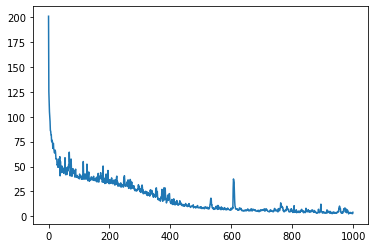

In [35]:
# Fit model to the data (train the model)
from keras.callbacks import History
history = History()

model.fit(X_train, Y_train, batch_size=5, epochs=1000, verbose=1, callbacks=[history])
# Batch size = 50 (all samples), epoch number = 10000 (the learning algorithm works through the entire dataset for 10000 times)
print('Done!')

# Plot the loss history
plt.plot(history.history['loss'])
plt.xlabel("epochs")
plt.ylabel("mean squared error")

Text(0, 0.5, 'mean squared error')

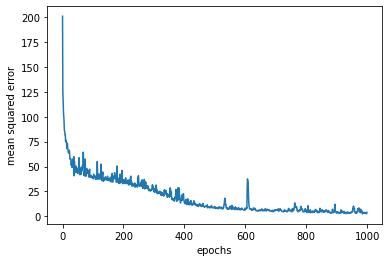

In [36]:
plt.plot(history.history['loss'],)
plt.xlabel("epochs")
plt.ylabel("mean squared error")

1/1 [==============================] - 0s 26ms/step - loss: 64.4531 - accuracy: 0.0000e+00
[64.45314025878906, 0.0]


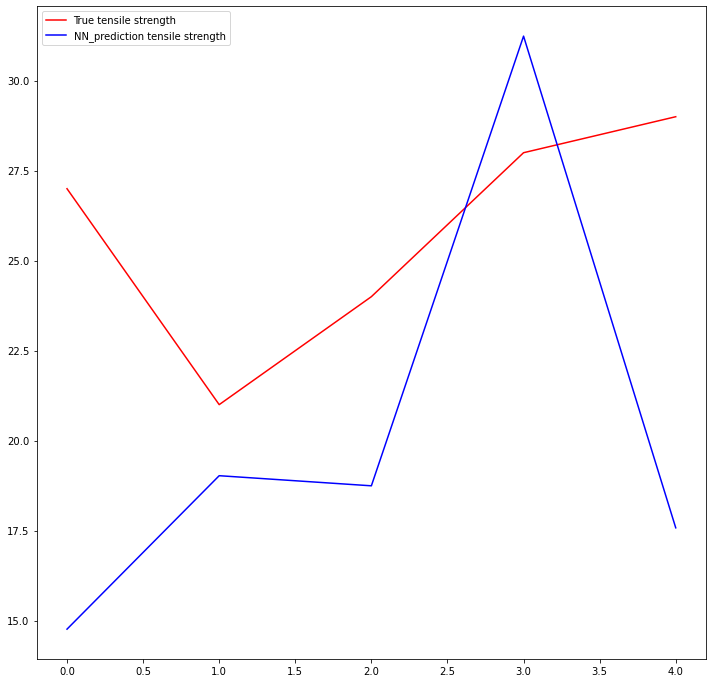

In [40]:
# Evaluate the accuracy of the model (loss: mean squared error, as defined in the step of compiling)
score = model.evaluate(X_test, Y_test, verbose=1)
print(score)

# Batch prediction & plot
Y_pred = model.predict(X_test)


plt.show()
plt.figure(figsize=(12, 12))
line1, = plt.plot(Y_test[:,0],'r-')
line2, = plt.plot(Y_pred[:,0],'b-')
#line3, = plt.plot(Y_test[:,1],'r--')
#line4, = plt.plot(Y_pred[:,1],'b--')
#line5, = plt.plot(Y_test[:,2],'r:')
#line6, = plt.plot(Y_pred[:,2],'b:')
plt.legend([line1, line2], ['True tensile strength', 'NN_prediction tensile strength', 'True roughness', 'NN_prediction roughness', 'True elongation', 'NN_prediction elongation'])